Automatisierte Multiobjektclusterung mithilfe von Machine-Learning-Verfahren - Methoden der optimalen Clusterung verschiedener Datensätze mit Hilfe eines neuronalen Netzes von
Robert Vetter, Hagen Jacob, Edgar König

In [1]:
# Importieren notwendiger Module

# Standardbibliotheken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Synthetische Generierung von Datensätzen sowie Bewertung
from sklearn.datasets import make_blobs, make_moons, make_circles, make_gaussian_quantiles
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, f1_score
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors

# Ausreißererkennung, Formerkennung
from scipy.ndimage import gaussian_filter
import scipy.stats as stats
from sklearn.neighbors import LocalOutlierFactor
from numpy import quantile, where
import cv2
from scipy.stats import gaussian_kde
from scipy import ndimage

# neuronale Netz, Generierung von Trainingsdaten
from sklearn.preprocessing import StandardScaler, RobustScaler
from skimage import measure
from matplotlib.patches import Polygon
from shapely.geometry import Polygon, Point
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import os

In [2]:
# Mögliche synthetische Datensätze zum Testen
# data, y = make_blobs(n_samples=2000, n_features=2, centers=2)
# data, y = make_circles(n_samples=1200, noise=0.08, factor=0.3, random_state=9187)
# data, y = make_gaussian_quantiles(n_samples=1500, n_features=2, n_classes=3, random_state=2310)
# data, y = make_gaussian_quantiles(n_samples=500, n_features=2, n_classes=5, random_state=3333)
# data , y = make_moons(n_samples=2500, noise=0.08, random_state = 45)
# data, y = make_blobs(n_samples=200, centers=3, cluster_std=0.1, random_state=7202)
data, y = make_blobs(n_samples=2000, n_features=2, centers=3, cluster_std=0.5, shuffle=True, random_state=3)
# data, y = make_circles(n_samples=2000, noise=.05, random_state=42, factor=0.3)
# data, y = make_blobs(n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=171)
# data, y = make_gaussian_quantiles(n_samples=400, n_features=2, n_classes=3)
# data, y = make_blobs(n_samples=2647, n_features=2, centers=6, cluster_std=1.5, shuffle=True, random_state=5)


# Datensätze aus realen Welt
# iris = datasets.load_iris()
# data = iris.data[:, :2]
# y = iris.target

# wine = datasets.load_wine()
# data = wine.data[:, :2]
# y = wine.target

# bc = datasets.load_breast_cancer()
# data = bc.data[:, :2]
# y = bc.target

# linnerud = datasets.load_linnerud()
# data = linnerud.data[:, :2]
# y = linnerud.target[:, 0]

# olivetti_faces = datasets.fetch_olivetti_faces()
# data = olivetti_faces.data[:, :2]
# y = olivetti_faces.target

# zu groß, mehr als 500.000 Punkte
# covtype = datasets.fetch_covtype()
# data = covtype.data[:, :2]
# y = covtype.target

# zu groß, ca. 30.000 Punkte
# california_housing = datasets.fetch_california_housing()
# data = california_housing.data[:, :2]
# y = california_housing.target




x = data

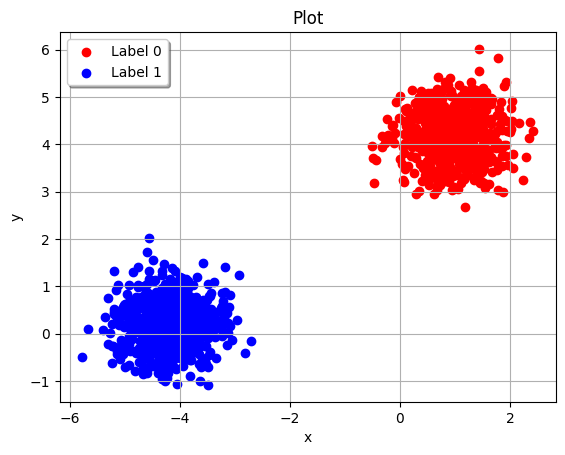

In [3]:
# Methode zum Abbilden des Datensatzes (erster Eindruck)
def plot_data(x, labels, title):
    plt.scatter(x[labels == 0, 0], x[labels == 0, 1], color='r', label="Label 0")
    plt.scatter(x[labels == 1, 0], x[labels == 1, 1], color='b', label="Label 1")
    plt.legend(loc="best", fancybox=True, shadow=True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.title(title)
    plt.show()

plot_data(data, y, "Plot")

Ausreißererkennung

In [4]:
# bestes Epsilon für DBSCAN ermitteln (DBSCAN wichtig für Ausreißererkennung)
def determine_epsilon(x, min_samples):
    # Distanzen zu nächsten k Nachbarn (mit k = min_pts) werden berechnet
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(x)
    distances, _ = nbrs.kneighbors(x)

    # Sortierung der Distanzen
    distances = np.sort(distances, axis=0)

    # für jeden Punkt wird größte Distanz zu MinPts-Nachbarn gewählt
    distances = distances[:, -1]

    # maximal 7% Rauschpunkte
    epsilon = quantile(distances, .93)
    return epsilon


def noise_detection(x, n_neighbors, contamination):
    # LOF
    lof_model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    lof_scores = -lof_model.fit_predict(x)
    lof_thresh = np.quantile(lof_scores, .999)
    lof_index = np.where(lof_scores >= lof_thresh)

    # verschiedene Werte für min_samples
    min_samples_range = range(2 * x.shape[1], 3 * x.shape[1])

    best_sil_score = -1
    best_min_samples = None
    best_epsilon = None

    # bestes MinSamples ermitteln (verschiedene Werte durchprobieren und immer mit Silhouette-Score bewerten)
    for min_samples in min_samples_range:
        epsilon = determine_epsilon(x, min_samples)
        model = DBSCAN(eps=epsilon, min_samples=min_samples).fit(x)
        labels = model.labels_

        # Bewertung basierend auf dem Silhouette-Score, nur möglich, wenn mehr als 1 Cluster (-1 markiert Rauschpunkte, wird nicht als Cluster angesehen, dennoch label)
        if len(set(labels)) > 2:
            # keine Rauschpunkte
            silhouette_avg = silhouette_score(x[labels != -1], labels[labels != -1])

            # wenn besser, aktualisiere
            if silhouette_avg > best_sil_score:
                best_sil_score = silhouette_avg
                best_min_samples = min_samples
                best_epsilon = epsilon
        else:
            best_epsilon = epsilon
            best_min_samples = min_samples

    # DBSCAN anwenden
    model = DBSCAN(eps=best_epsilon, min_samples=best_min_samples).fit(x)
    labels = model.labels_
    dbscan_index = np.where(labels == -1)

    # Kombination der Ergebnisse aus LOF und DBSCAN
    all_outliers = np.unique(np.concatenate([dbscan_index[0], lof_index[0]]))

    return best_min_samples, best_epsilon, all_outliers



In [5]:
# probiert mögliche Parameter für LOF aus und bewertet Ergebnisse mittels F1-Score (da dieser besonders auf Ausreißer spezialisiert ist (da unausgewogene Klassenverteilung))
def grid_search_lof(x, y):
    best_score = -1
    best_params = {'n_neighbors': None, 'contamination': None}

    # probiere verschiedene Werte aus
    for n_neighbors in range(10, 25):
        for contamination in [0.01, 0.02, 0.03]:
            # wende jeweils LOF an
            lof_model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
            y_pred = lof_model.fit_predict(x)
            y_pred = [1 if x == -1 else 0 for x in y_pred]

            # bewerte mittels F1
            score = f1_score(y, y_pred, average='macro')

            # wenn besser, aktualisiere
            if score > best_score:
                best_score = score
                best_params['n_neighbors'] = n_neighbors
                best_params['contamination'] = contamination
    return best_params, best_score


In [6]:
# Hauptmethode zur Ausreißererkennung (koordiniert)
def outlier_removal(x, y):
    # beste Parameter für LOF
    best_params, _ = grid_search_lof(x, y)

    # beste Werte für Epsilon
    best_min_samples, best_epsilon, all_outliers = noise_detection(x, best_params['n_neighbors'], best_params['contamination'])

    # identifiziere alle Ausreißer
    outlier_mask = np.ones(x.shape[0], dtype=bool)
    outlier_mask[all_outliers] = False
    x_without_outliers = x[outlier_mask]
    y_without_outliers = y[outlier_mask]
    
    return x_without_outliers, y_without_outliers, best_epsilon, best_min_samples

x_without_outliers, y_without_outliers, _, _ = outlier_removal(x, y)
data = x_without_outliers


Konturen ermitteln nach Methode 1 (3D-Dichteschätzung)

In [7]:
# 3D-Dichteschätzung
def gaussian_density_estimation(data):

    # Dichteverteilung dreidimensional
    density = gaussian_kde(data.T)
    x = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 100)
    y = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 100)
    X, Y = np.meshgrid(x, y)
    Z = np.reshape(density(np.vstack([X.ravel(), Y.ravel()])).T, X.shape)
    Z_smooth = gaussian_filter(Z, sigma=1)

    return X, Y, Z, Z_smooth

X, Y, Z, Z_smooth = gaussian_density_estimation(x_without_outliers)


In [8]:
# grafische Visualisierung
def plot_contour(best_contour_points, X, Y, Z):
    plt.figure()

    # plotte die Kontur mit dem besten Faktor
    for contour in best_contour_points:
        x, y = zip(*contour)
        plt.plot(x, y, color='red')

    
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Contour Plot Method 1")
    plt.show()
    

In [9]:

# nimmt Konturen und Datenpunkte als Parameter entgegen -> weist jedem Punkt in einer Kontur dasselbe Label zu, sodass ale Punkte in einer Kontur quasi einem CLuster angehören
def berechne_silhouette_score(contour_points, data_points):
    # vereinfache Konturen, damit nicht so rechenaufwendig
    simplified_polygons = [Polygon(contour).simplify(0.1, preserve_topology=False) for contour in contour_points]
    cluster_labels = []
    # gehe alle Datenpunkte durch und überprüfe jeweils, ob Punkt in einer Kontur liegt -> wenn nein, dann Ausreißer
    for point in data_points:
        for i, polygon in enumerate(simplified_polygons):
            if polygon.contains(Point(point)):
                cluster_labels.append(i)
                break
        else:
            cluster_labels.append(-1)

    unique_labels = np.unique(cluster_labels)

    if len(unique_labels) < 2:
        return -1, cluster_labels

    return silhouette_score(data_points, cluster_labels), cluster_labels


    

In [10]:
# ermittle Konturen der 3D-Dichteverteilung
def get_contours_with_factor(factor, X, Y, Z):
    # Durchschnittswert von Z
    mean_z = np.mean(Z.ravel())

    # Überprüfung ob factor * mean_z größer als Z-Werte -> wenn ja, keine Konturen (weil über maximalen Z-Wert)
    if np.all(factor * mean_z > Z):
        print("ha")
        return []
    
    # Erstellung Plot
    fig, ax = plt.subplots()

    # Konturenzeichnung basierend auf factor * mean_z
    contours = ax.contour(X, Y, Z, [factor * mean_z])
    
    # Schließen des Plots
    plt.close(fig)
    
    # Überprüfung ob Konturen vorhanden
    if not contours.get_paths():
        return []
    
    # Extraktion der Konturpfade
    contour_paths = contours.get_paths()

    # Weiterer Check auf leere Pfade
    if not contour_paths:
        return []
    
    # Sammeln aller Konturpunkte
    all_contour_points = []
    for path in contour_paths:
        vertices = path.vertices
        contour_points = vertices.tolist()
        all_contour_points.append(contour_points)
    
    # Rückgabe der gesammelten Konturpunkte
    return all_contour_points

Bester Faktor:  0.7


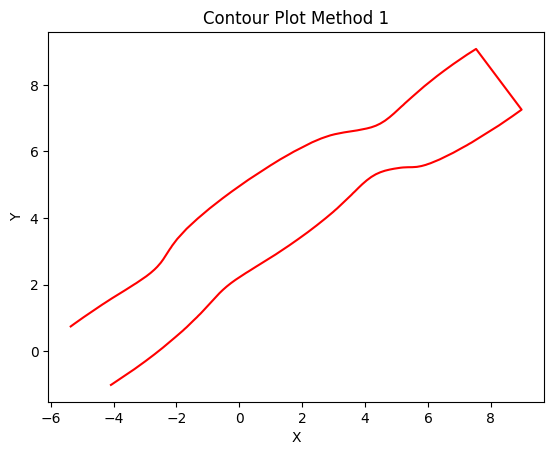

In [11]:

# Methode, um besten Faktor zu ermitteln -> verschiedene Faktoren durchgehen, Konturen ermitteln, mit SIlhouette bewerten und beste Konturen mit besten Faktor zurückgeben
def find_best_factor(factors, X, Y, Z, data_points):
    best_factor = None
    best_silhouette_score = -1
    best_contour_points = None
    
    for factor in factors:
        contour_points = get_contours_with_factor(factor, X, Y, Z)
        if not contour_points:
            continue

        silhouette, _ = berechne_silhouette_score(contour_points, data_points)


        if silhouette >= best_silhouette_score:
            best_silhouette_score = silhouette
            best_factor = factor
            best_contour_points = contour_points
    
    return best_contour_points, best_factor

factors = [0.7, 1.0, 1.5, 3.0]
contour_points_method1, best_fac = find_best_factor(factors, X, Y, Z, x_without_outliers)
print("Bester Faktor: ", best_fac)
plot_contour(contour_points_method1, X, Y, Z)

Konturen ermitteln nach Methode 2 (Histogramm)

In [12]:
padding_percentage = 0.2

# Histogramm erstellen 
def prepare_data_and_create_histogram(data, padding_percentage, bins=[64, 64]):
    x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
    y_min, y_max = np.min(data[:, 1]), np.max(data[:, 1])

    x_range = x_max - x_min
    y_range = y_max - y_min

    # Skalierung, damit gesamte Histogramm auf Grafik
    x_min -= x_range * padding_percentage
    x_max += x_range * padding_percentage
    y_min -= y_range * padding_percentage
    y_max += y_range * padding_percentage

    # erstelle das 2D Histogramm
    hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=bins, range=[[x_min, x_max], [y_min, y_max]])

    return hist, x_min, x_max, y_min, y_max

In [13]:
# auf Histogramm Sobel-Operator und Gauß-Filter anwenden, Konturen finden
def process_histogram(hist, sigma):
    dx = ndimage.sobel(hist, 0)
    dy = ndimage.sobel(hist, 1)
    mag = np.hypot(dx, dy)

    # Guaß-Filter anweden
    smoothed_mag = gaussian_filter(mag, sigma=sigma)

    binary_image = smoothed_mag > 1
    contours = measure.find_contours(binary_image, 0.8)

    return smoothed_mag, contours

In [14]:
# Konturen noch einmal skalieren, Punkte der Konturen zurückgeben
def scale_contours(contours, x_min, x_max, y_min, y_max, bins=[64, 64]):
    scaled_contours = []
    for contour in contours:
        scaled_contour = np.empty_like(contour)
        scaled_contour[:, 0] = x_min + contour[:, 0] * (x_max - x_min) / bins[0]
        scaled_contour[:, 1] = y_min + contour[:, 1] * (y_max - y_min) / bins[1]
        scaled_contours.append(scaled_contour)

    contour_points_method2 = [[[p[0], p[1]] for p in contour] for contour in scaled_contours]

    return contour_points_method2

In [15]:
# Hilfsfunktion, die lediglich alle Methoden zur Konturbestimmung nach Methode 2 aufruft
def berechne_histogram_und_skaliere_konturen(data_points, sigma):
    hist, x_min, x_max, y_min, y_max = prepare_data_and_create_histogram(data_points, padding_percentage)
    _, contours = process_histogram(hist, sigma)
    return scale_contours(contours, x_min, x_max, y_min, y_max)

In [16]:
# bestes Sigma für Gauß-Filter finden -> für jedes Sigma Konturen berechnen und Silhouette-Score -> bester Silhouette-Score ist bestes Sigma
def find_best_sigma(sigma_values, data_points):
    best_sigma = None
    best_silhouette_score = -1
    best_contour_points = None

    # alle Sigma-Werte durchgehen und immer Silouette-Score berechnen
    for sigma in sigma_values:
        contour_points_method2 = berechne_histogram_und_skaliere_konturen(data_points, sigma)
        silhouette_score, labels = berechne_silhouette_score(contour_points_method2, data_points)

        if silhouette_score > best_silhouette_score:
            best_silhouette_score = silhouette_score
            best_sigma = sigma
            best_contour_points = contour_points_method2

    # wenn kein Sigma gefunden, nehme Standardwert
    if best_sigma is None:
        best_contour_points = berechne_histogram_und_skaliere_konturen(data_points, 1.5)

    # Filtere Konturen, die keine Punkte enthalten
    valid_contours = []
    for contour in best_contour_points:
        polygon = Polygon(contour)
        punkte_in_polygon = [point for point in data_points if polygon.contains(Point(point[0], point[1]))]
        if punkte_in_polygon:
            valid_contours.append(contour)


    return valid_contours, best_sigma

Auswahl der besten Kontur

In [17]:
# Konturpunkte beider Methoden über Silhouette vergleichen
def entscheide_ueber_beste_methode(contour_points_method1, contour_points_method2, data_points):
    # Berechne Silhouette-Scores für beide Methoden
    silhouette_score1, labels1 = berechne_silhouette_score(contour_points_method1, data_points)
    silhouette_score2, labels2 = berechne_silhouette_score(contour_points_method2, data_points)

    # Entscheide, welche Methode besser ist
    if silhouette_score1 > silhouette_score2:
        return contour_points_method1, "method1", labels1
    else:
        return contour_points_method2, "method2", labels2


In [18]:
sigma_values = [0.7, 1, 1.5, 3]
contour_points_method2, best_sigma = find_best_sigma(sigma_values, x_without_outliers)
contour_points, best_method, _ = entscheide_ueber_beste_methode(contour_points_method1, contour_points_method2, x_without_outliers)
print(best_method)

method2


Grafische Veranschaulichung

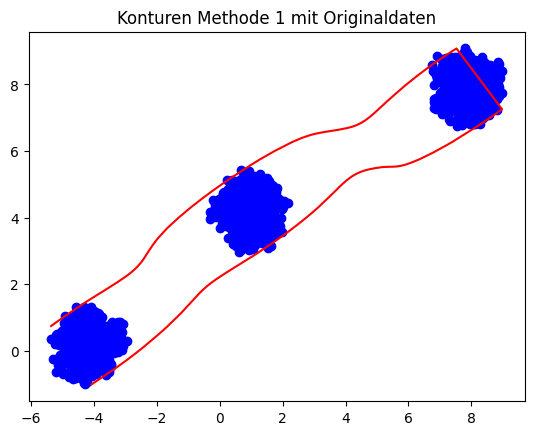

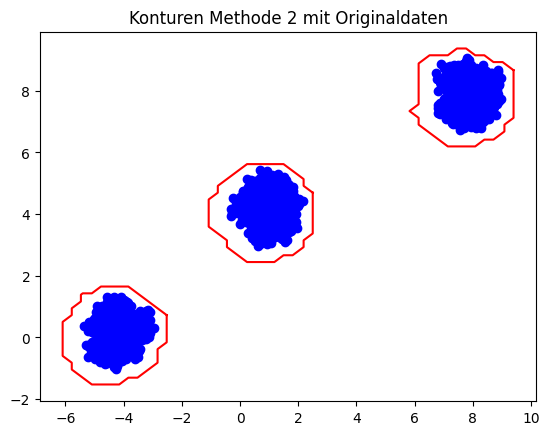

In [19]:
# grasiche Veranschaulichung der Konturen
def plot_konturen_mit_originaldaten(konturpunkte, originaldaten, title):
    original_x = [punkt[0] for punkt in originaldaten]
    original_y = [punkt[1] for punkt in originaldaten]
    plt.scatter(original_x, original_y, color='blue')

    for kontur in konturpunkte:
        kontur_x = [punkt[0] for punkt in kontur]
        kontur_y = [punkt[1] for punkt in kontur]
        plt.plot(kontur_x, kontur_y, color='red')

    plt.title(title)
    plt.show()

plot_konturen_mit_originaldaten(contour_points_method1, x_without_outliers, "Konturen Methode 1 mit Originaldaten")
plot_konturen_mit_originaldaten(contour_points_method2, x_without_outliers, "Konturen Methode 2 mit Originaldaten")



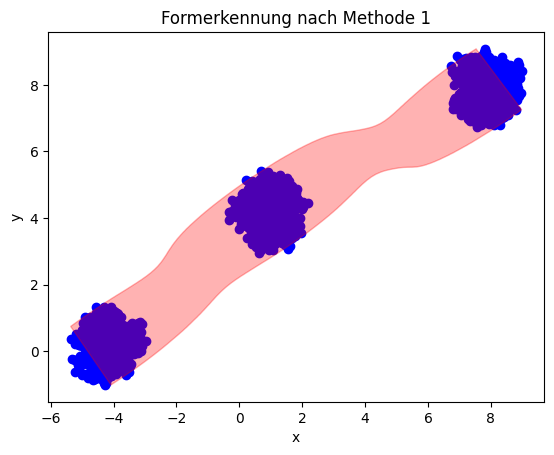

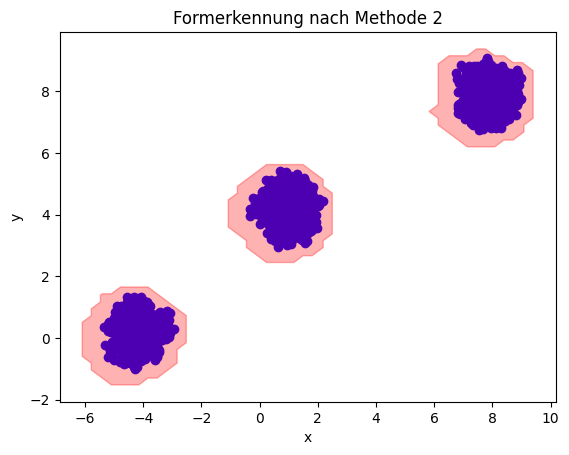

In [20]:
# ausgefüllte Konturen plotten
def plot_filled_contours(contours, original_data, title):
    original_x = [point[0] for point in original_data]
    original_y = [point[1] for point in original_data]
    plt.scatter(original_x, original_y, color='blue')

    for contour in contours:
        contour_x = [point[0] for point in contour]
        contour_y = [point[1] for point in contour]
        plt.fill(contour_x, contour_y, color='red', alpha=0.3)

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plot_filled_contours(contour_points_method1, x_without_outliers, "Formerkennung nach Methode 1")
plot_filled_contours(contour_points_method2, x_without_outliers, "Formerkennung nach Methode 2")


Berechnung der Features

In [21]:
# eukl. Distanz mithilfe des S.d.P.
def euklidische_distanz(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

In [22]:
# Exzentrizitäten der Konturen berechnen -> sowohl Durchschnitt als auch Standardabweichung, wird mithilfe von cv2 realisiert
# je näher bei 0, desto kreisförmiger, je näher bei 1, desto elliptischer
def berechne_exzentrizitaet(contour_points):
    exzentrizitaeten = []

    for contour in contour_points:
        contour_array = np.array(contour, dtype=np.float32)


        if len(contour) >= 5:
            (x,y),(MA,ma),angle = cv2.fitEllipse(contour_array)

            if ma != 0:
                exzentrizitaet = np.sqrt(1 - (MA/ma)**2)
                exzentrizitaeten.append(exzentrizitaet)

    if not exzentrizitaeten:
        return 0, 0 

    return np.mean(exzentrizitaeten), np.std(exzentrizitaeten)




In [23]:
# Kurtosis und Skewness berechnen -> statistische Größen (sowohl jeweils Durchschnitt und Std zurückgeben)
def calc_kurtosis_and_skewness(data):
    kurtosis_vals = stats.kurtosis(data)
    skewness_vals = stats.skew(data)
    return np.mean(kurtosis_vals), np.std(kurtosis_vals), np.mean(skewness_vals), np.std(skewness_vals)



In [24]:
# Verhältnis der Fläche, die von Kontur eingeschlossen wird zu Fläche der konvexen Hülle der Kontur
# je größer, desto genauer liegen Kontur und konvexen Hülle zusammen -> kreisförmiger 

def berechne_verhaeltnis_konvexe_huelle(contour_points):
    verhaeltnisse = []

    for contour in contour_points:
        contour_array = np.array(contour, dtype=np.float32)

        # Fläche der Kontur berechnen
        kontur_flaeche = cv2.contourArea(contour_array)

        # Konvexe Hülle der Kontur berechnen
        hull = cv2.convexHull(contour_array)

        # Fläche der konvexen Hülle berechnen
        hull_flaeche = cv2.contourArea(hull)

        # Verhältnis berechnen
        if hull_flaeche == 0:
            verhaeltnis = 0
        else:
            verhaeltnis = kontur_flaeche / hull_flaeche

        verhaeltnisse.append(verhaeltnis)

    return np.mean(verhaeltnisse)


In [25]:
# Varianz der Distanzen zu Schwerpunkt -> genauere Vorstellung über geometrische Lage der Punkte
def variance_of_distances(data):
    centroid = np.mean(data, axis=0)
    distances = np.sqrt(np.sum((data - centroid)**2, axis=1))
    return np.var(distances)


In [26]:
# Verhältnis der Fläche der Kontur zu der Anzahl der Punkte in der Kontur 
def contour_area_to_points_area_ratio(contours, data_points):
    total_ratio = 0
    
    for contour in contours:
        # Fläche der Kontur
        contour_polygon = Polygon(contour)
        contour_area = contour_polygon.area
        
        # Punkte innerhalb der Kontur finden
        points_inside = [p for p in data_points if contour_polygon.contains(Point(p))]
        
        # Annahme: Jeder Punkt hat eine Fläche von 1
        points_area = len(points_inside)
        
        if contour_area != 0:
            total_ratio += contour_area / points_area

    # Durchschnittliches Verhältnis aller Konturen
    average_ratio = total_ratio / len(contours) if contours else 0
    
    return average_ratio



In [27]:
# Schwerpunkt (Hilfsfunktion) und Kompaktheit (statistisches Maß) berechnen 
def berechne_schwerpunkt(points):
    return np.mean(points, axis=0)

def berechne_kompaktheit(points, centroid):
    distances = np.linalg.norm(points - centroid, axis=1)
    compactness = np.mean(distances**2)
    return compactness

Alle Features in einer Methode berechnen

In [28]:
sigma_values = [0.7, 1, 1.5, 3]


def calc_unscaled_features(X, y):
    # Punkte ohne Ausreißer
    x_without_outliers, _, _, _ = outlier_removal(X, y)

    schwerpunkt = berechne_schwerpunkt(x_without_outliers)

    # Koordinaten der Maxima
    X_, Y, Z, _ = gaussian_density_estimation(x_without_outliers)

    # Konturpunkte Methode 1
    contour_points_method1, _ = find_best_factor(factors, X_, Y, Z, x_without_outliers)
    # Konturpunkte Methode 2
    contour_points_method2, _ = find_best_sigma(sigma_values, x_without_outliers)

    # Besten Konturpunkte (entweder 1 oder 2)
    contour_points, _, _ = entscheide_ueber_beste_methode(contour_points_method1, contour_points_method2, x_without_outliers)

    

    # Berechnung aller Features
    mean_exzentrizitaet, std_exzentrizitaet = berechne_exzentrizitaet(contour_points)

    mean_verhaeltnis_konvev_flaeche = berechne_verhaeltnis_konvexe_huelle(contour_points)

    varianz_distanzen_schwerpunkt_punkte = variance_of_distances(x_without_outliers)

    verhaeltnis_kontur_flaeche_punkte_flaeche = contour_area_to_points_area_ratio(contour_points, x_without_outliers)

    kompaktheit = berechne_kompaktheit(x_without_outliers, schwerpunkt)

    kurtosis, std_kurtosis, skewness, std_skewness = calc_kurtosis_and_skewness(X)

    

    unscaled_features = np.array([mean_exzentrizitaet,std_exzentrizitaet, mean_verhaeltnis_konvev_flaeche, varianz_distanzen_schwerpunkt_punkte, verhaeltnis_kontur_flaeche_punkte_flaeche, kurtosis,std_kurtosis, 
                                  skewness, std_skewness, kompaktheit])

    return unscaled_features

unscaled_features = calc_unscaled_features(x, y)
print(unscaled_features)

[ 4.80228366e-01  1.38172536e-02  9.67289163e-01  9.18546057e+00
  1.39242240e-02 -1.44866248e+00  2.12044441e-02  6.45361247e-02
  1.08360290e-01  3.46604617e+01]


Klasse, um Datensätze leicht abzuändern

In [30]:
# Klasse, um einen Datensatz zu variieren -> Erhöhung der verschiedenen Datensätze, robuster
class DataAugmentor:
    def __init__(self, data: np.ndarray):
        self.data = data
        self.n_samples, self.n_features = data.shape

    # entferne Punkte
    def remove_points(self, n: int):
        indices = np.random.choice(self.n_samples, size=n, replace=False)
        return np.delete(self.data, indices, axis=0)

    # füge Punkte hinzu
    def add_points(self, n: int):
        indices = np.random.choice(self.n_samples, size=n)
        additional_points = self.data[indices] + 0.05 * np.random.randn(
            n, self.n_features
        )
        return np.vstack([self.data, additional_points])

    # skaliere Punkte
    def scale_data(self, scale_factor: float):
        return self.data * scale_factor

    # verschiebe Punkte
    def shift_points(self, shift_factor: float):
        shifts = (
            (np.random.rand(self.n_samples, self.n_features) - 0.5) * 2 * shift_factor
        )
        return self.data + shifts

    # rotiere um den Schwerpunkt
    def rotate_around_centroid(self, theta: float):
        # Berechne den Schwerpunkt der Daten
        centroid = np.mean(self.data, axis=0)

        # Verschiebe die Daten, so dass der Schwerpunkt im Ursprung liegt
        shifted_data = self.data - centroid

        # Rotationsmatrix
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        # Drehe die Punkte
        rotated_data = np.dot(shifted_data, R.T)

        # Verschiebe die Daten zurück
        return rotated_data + centroid

    def augment(self):
        result_data = self.data.copy()

        # Entfernen von Datenpunkten
        remove_factor = np.random.randint(1, self.n_samples)
        result_data = self.remove_points(remove_factor)

        # Hinzufügen von Datenpunkten
        add_factor = np.random.randint(1, self.n_samples)
        result_data = self.add_points(add_factor)

        # Skalieren der Daten
        scale_factor = 0.5 + np.random.rand()
        result_data = self.scale_data(scale_factor)

        # Verschieben der Datenpunkte
        shift_factor = 0.05
        result_data = self.shift_points(shift_factor)

        # Rotation um einen zufälligen Winkel | funktioniert nur für 2D Daten
        theta = np.random.rand() * 2 * np.pi  # Zufälliger Winkel zwischen 0 und 2π
        result_data = self.rotate_around_centroid(theta)

        return result_data

Generatoren

In [279]:
warnings.filterwarnings("ignore")

# Parameter für blobs, circles
n_samples_range = [500, 800, 1000, 1200, 1500, 1700, 2000, 2500, 4000]
n_clusters_range = [3, 4, 5, 6]
noise_range = [0.02, 0.04, 0.06]
factors = [0.3, 0.5]

# Parameter für moons, quantiles
n_samples_range_moons = [500, 800, 1000, 1200, 1500, 1700, 2000, 2500, 4000]
n_samples_range_quantiles = [500, 800, 1000, 1200, 1500, 1700, 2000, 2500, 4000]
noise_range_moons = [0.02, 0.04, 0.06]
noise_range_quantiles = [0.02, 0.04, 0.06]
n_classes_range = [1, 2, 3]

n_augment = 2


n_iter_per_combination_first = 2
n_iter_per_combination_second = 16

datasets = []

best_algorithms_blobs = ["KMeans"] * n_iter_per_combination_first
best_algorithms_circles = ["OPTICS"] * n_iter_per_combination_first
best_algorithms_moons = ["DBSCAN"] * n_iter_per_combination_second
best_algorithms_gaussian_quantiles = ["GMM"] * n_iter_per_combination_second

scaler = StandardScaler()

# durch alle Parameter durch iterieren (von Blobs, Circles)
for n_samples in n_samples_range:
    for n_clusters in n_clusters_range:
        for noise in noise_range:
            for i in range(n_iter_per_combination_first):
                for j in factors:

                    random_state = np.random.randint(10000)

                    # Blobs
                    X, y = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=noise, random_state=random_state)
                    data_augmentor = DataAugmentor(X)
                    
                    for k in range(n_augment):
                        augmentedData = data_augmentor.augment()
                        datasets.append((augmentedData, y, best_algorithms_blobs[i]))
                    
                    datasets.append((X, y, best_algorithms_blobs[i]))

                    # Circles
                    X, y = make_circles(n_samples=n_samples, noise=noise, factor=j, random_state=random_state)
                    data_augmentor = DataAugmentor(X)
                    
                    for k in range(n_augment):
                        augmentedData = data_augmentor.augment()
                        datasets.append((augmentedData, y, best_algorithms_circles[i]))
                    
                    datasets.append((X, y, best_algorithms_circles[i]))


# durch alle Parameter durch iterieren (von Moons)
for n_samples in n_samples_range_moons:
    for noise in noise_range_moons:
        for i in range(n_iter_per_combination_second):

            random_state = np.random.randint(10000)

            # Moons
            X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
            data_augmentor = DataAugmentor(X)
            
            for k in range(n_augment):
                augmentedData = data_augmentor.augment()
                datasets.append((augmentedData, y, best_algorithms_moons[i]))
            
            datasets.append((X, y, best_algorithms_moons[i]))

                

for n_samples in n_samples_range_quantiles:
    for n_classes in n_classes_range:
        for i in range(n_iter_per_combination_second):

            random_state = np.random.randint(10000)

            X, y = make_gaussian_quantiles(n_samples=n_samples, n_features=2, n_classes=n_classes, random_state=random_state)

            data_augmentor = DataAugmentor(X)
            
            for k in range(n_augment):
                augmentedData = data_augmentor.augment()
                datasets.append((augmentedData, y, best_algorithms_gaussian_quantiles[i]))

            datasets.append((X, y, best_algorithms_gaussian_quantiles[i]))


feature_list = []
label_list = []

counter = 0
all_unscaled_features = []

length = len(datasets)

# jeden generierten Datensatz durchgehen und Features berechnen
for x, y, best_algorithm in datasets:
    x = np.array(x)
    y = np.array(y)
    unscaled_features = calc_unscaled_features(x, y)
    all_unscaled_features.append(unscaled_features)
    label_list.append(best_algorithm)

    counter += 1
    print("Durchlauf: ", counter, " / ", length)

all_unscaled_features_array = np.vstack(all_unscaled_features)

# in Pandas dataframe schreiben
df_unscaled = pd.DataFrame(all_unscaled_features_array, columns=[f"Feature {i+1}" for i in range(all_unscaled_features_array.shape[1])])
df_unscaled['Best Algorithm'] = label_list

df_scaled = df_unscaled.copy()

# diesmal mit RobustScaler (nicht so sensibel für Ausreißer) Daten spaltenweise skalieren
scaler = RobustScaler()
for col in df_scaled.columns:
    if col != 'Best Algorithm':
        df_scaled[col] = scaler.fit_transform(df_scaled[col].values.reshape(-1, 1)).reshape(-1)

cols = ['Best Algorithm'] + [col for col in df_scaled if col != 'Best Algorithm']
df_scaled = df_scaled[cols]

# skalierten und unskalierten Daten abspeichern
filename_unscaled = 'daten_unscaled.xlsx'
filepath_unscaled = os.path.join(os.getcwd(), filename_unscaled)
df_unscaled.to_excel(filepath_unscaled, index=False, engine='openpyxl')
print(f"Unskalierte Daten wurden erfolgreich gespeichert unter: {filepath_unscaled}")

filename_scaled = 'daten_scaled.xlsx'
filepath_scaled = os.path.join(os.getcwd(), filename_scaled)
df_scaled.to_excel(filepath_scaled, index=False, engine='openpyxl')
print(f"Skalierte Daten wurden erfolgreich gespeichert unter: {filepath_scaled}")




1 476
Durchlauf:  1  /  5184
1 476
Durchlauf:  2  /  5184
1 476
Durchlauf:  3  /  5184
1 481
Durchlauf:  4  /  5184
1 481
Durchlauf:  5  /  5184
1 481
Durchlauf:  6  /  5184
1 479
Durchlauf:  7  /  5184
1 479
Durchlauf:  8  /  5184
1 479
Durchlauf:  9  /  5184
1 484
Durchlauf:  10  /  5184
1 484
Durchlauf:  11  /  5184
1 484
Durchlauf:  12  /  5184
1 476
Durchlauf:  13  /  5184
1 476
Durchlauf:  14  /  5184
1 476
Durchlauf:  15  /  5184
1 484
Durchlauf:  16  /  5184
1 484
Durchlauf:  17  /  5184
1 484
Durchlauf:  18  /  5184
1 482
Durchlauf:  19  /  5184
1 482
Durchlauf:  20  /  5184
1 482
Durchlauf:  21  /  5184
1 485
Durchlauf:  22  /  5184
1 485
Durchlauf:  23  /  5184
1 485
Durchlauf:  24  /  5184
1 478
Durchlauf:  25  /  5184
1 478
Durchlauf:  26  /  5184
1 478
Durchlauf:  27  /  5184
1 483
Durchlauf:  28  /  5184
1 483
Durchlauf:  29  /  5184
1 483
Durchlauf:  30  /  5184
1 477
Durchlauf:  31  /  5184
1 477
Durchlauf:  32  /  5184
1 477
Durchlauf:  33  /  5184
1 484
Durchlauf:  3

KeyboardInterrupt: 

Neuronales Netz

In [29]:


# Hyperparameter und Einstellungen
NEURONS_LAYER1 = 48
NEURONS_LAYER2 = 32
L2_REG = 0.01
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 15

df = pd.read_excel('daten_scaled.xlsx')

df['Best Algorithm'] = df['Best Algorithm'].map({'KMeans': 0, 'DBSCAN': 1, 'OPTICS': 2, 'GMM': 3})

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modell definieren
model = Sequential([
    Dense(NEURONS_LAYER1, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(L2_REG)),
    Dropout(DROPOUT_RATE),
    BatchNormalization(),
    Dense(NEURONS_LAYER2, activation='relu', kernel_regularizer=regularizers.l2(L2_REG)),
    Dropout(DROPOUT_RATE),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

# Modell kompilieren
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modell trainieren
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

# Modell evaluieren
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')




Epoch 1/100


c:\Python39\lib\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


104/104 [==============================] - 1s 3ms/step - loss: 2.3180 - accuracy: 0.3144 - val_loss: 1.7923 - val_accuracy: 0.5759
Epoch 2/100
104/104 [==============================] - 0s 1ms/step - loss: 2.1434 - accuracy: 0.3781 - val_loss: 1.6147 - val_accuracy: 0.7675
Epoch 3/100
104/104 [==============================] - 0s 1ms/step - loss: 1.9703 - accuracy: 0.4299 - val_loss: 1.4886 - val_accuracy: 0.8446
Epoch 4/100
104/104 [==============================] - 0s 1ms/step - loss: 1.8291 - accuracy: 0.4781 - val_loss: 1.3850 - val_accuracy: 0.8880
Epoch 5/100
104/104 [==============================] - 0s 1ms/step - loss: 1.7165 - accuracy: 0.5309 - val_loss: 1.3264 - val_accuracy: 0.9096
Epoch 6/100
104/104 [==============================] - 0s 2ms/step - loss: 1.6208 - accuracy: 0.5520 - val_loss: 1.2610 - val_accuracy: 0.9325
Epoch 7/100
104/104 [==============================] - 0s 2ms/step - loss: 1.5569 - accuracy: 0.5834 - val_loss: 1.2052 - val_accuracy: 0.9434
Epoch 8/100

Testen des NNs

In [32]:

# Datensätze
X, y = make_moons(n_samples=1000, noise=.35, random_state = 45)
# X, y = make_blobs(n_samples=5000, n_features=2, centers=3, cluster_std=0.8, shuffle=True, random_state=3)
# X, y = make_gaussian_quantiles(n_samples=400, n_features=2, n_classes=3)
# X, y = make_blobs(n_samples=2647, n_features=2, centers=6, random_state=42)
# X, y = make_blobs(n_samples=2647, centers=2, random_state=42)
# X, y = make_circles(n_samples=2000, factor=.8, noise=.1)
# X, y = make_moons(n_samples=1000, noise=.06, random_state=45)



unscaled_features = calc_unscaled_features(X, y)

# Bestes Epsilon, Min Samples und k finden
_, _, best_epsilon, best_min_samples = outlier_removal(X, y)


# Skalieren der unscaled_features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(unscaled_features.reshape(-1, 1)).reshape(1, -1)

# Model Prediction
predictions = model.predict(scaled_features)
best_algo = np.argmax(predictions)

print("Predictions: ", predictions)

print("Bester Algo: ")
# Ausgabe des besten Algorithmus
if best_algo == 0:
    print('KMeans')
elif best_algo == 1:
    print('DBSCAN')
elif best_algo == 2:
    print('OPTICS')
else:
    print('GMM')



ha
1/1 [==============================] - 0s 15ms/step
Predictions:  [[0.04767168 0.78197473 0.05665015 0.1137035 ]]
Bester Algo: 
DBSCAN
